In [1]:
# Import packages

# Classifiers Models
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from collections import Counter
from xgboost import XGBClassifier
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,
RandomForestClassifier, VotingClassifier, HistGradientBoostingClassifier, StackingClassifier)

# Preprocessing
from sklearn.feature_selection import SelectKBest, f_regression, RFE, RFECV
from sklearn.preprocessing import LabelEncoder, StandardScaler ,OneHotEncoder, MinMaxScaler, PolynomialFeatures

# model_selection
from sklearn.model_selection import (train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold, 
learning_curve, cross_val_predict, cross_validate, permutation_test_score, validation_curve, RandomizedSearchCV)

# Metrics
from sklearn.metrics import (accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, r2_score,
root_mean_squared_error, recall_score, roc_auc_score, roc_curve, mean_absolute_error, auc, classification_report, f1_score)

# Display all columns
#pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

## Breast Cancer Wisconsin

In [2]:
cln = ['Clump_Thickness', 'Uniformity_of_Cell_Size', 
       'Uniformity_of_Cell_Shape', 'Marginal_Adhesion', 'Single_Epithelial_Cell_Size',
       'Bare_Nuclei', 'Bland_Chromatin', 'Normal_Nucleoli', 'Mitoses', 'Class']

In [3]:
df = pd.read_csv('breast-cancer-wisconsin.csv',  names=cln, engine='pyarrow')
df.head()

,Clump_Thickness,Uniformity_of_Cell_Size,Uniformity_of_Cell_Shape,Marginal_Adhesion,Single_Epithelial_Cell_Size,Bare_Nuclei,Bland_Chromatin,Normal_Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [4]:
# Lowering columns
df.columns = df.columns.str.lower() 

In [5]:
# Data Integrity Check
print("Big Query Statistics:")
print('-' * 127)
print(f"🚣‍♀️ DataFrame Shape: {df.shape}")
print('-' * 127)
print(f"Columns to list:\n{df.columns.tolist()}")
print('-' * 127)
print(f"📊 DataFrame Info: {df.info(memory_usage='deep')}")
print('-' * 127)
print(f"📈 DataFrame Distribution:\n {df.describe()}")
print('-' * 127)

missing_values = df.isna().sum()

if len(missing_values) < 0:
    print("❌ Missing data for following columns:")
else:
    print(f"✅ No missing values for df:\n{missing_values}")

Big Query Statistics:
-------------------------------------------------------------------------------------------------------------------------------
🚣‍♀️ DataFrame Shape: (699, 10)
-------------------------------------------------------------------------------------------------------------------------------
Columns to list:
['clump_thickness', 'uniformity_of_cell_size', 'uniformity_of_cell_shape', 'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses', 'class']
-------------------------------------------------------------------------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   clump_thickness              699 non-null    int64 
 1   uniformity_of_cell_size      699 non-null    int64 
 2   uniform

In [6]:
# Value_counts - Unique
objects = df.select_dtypes(include=['object','category'])
for col in objects.columns:
    #print(f"\n{col}:")
    print(f"{'='*127}")
    print(df[col].unique()) 

['1' '10' '2' '4' '3' '9' '7' '?' '5' '8' '6']


In [7]:
# Replace ? with NaN values
df = df.replace('?', np.nan)

In [8]:
# Fillna
df.fillna({'bare_nuclei': '11'}, inplace=True) 

In [9]:
missing_values = df.isna().sum()

if len(missing_values) < 0:
    print("❌ Missing data for following columns:")
else:
    print(f"✅ No missing values for df:\n{missing_values}")

✅ No missing values for df:
clump_thickness                0
uniformity_of_cell_size        0
uniformity_of_cell_shape       0
marginal_adhesion              0
single_epithelial_cell_size    0
bare_nuclei                    0
bland_chromatin                0
normal_nucleoli                0
mitoses                        0
class                          0
dtype: int64


In [10]:
# Dtype change
df['bare_nuclei'] = df['bare_nuclei'].astype('int')

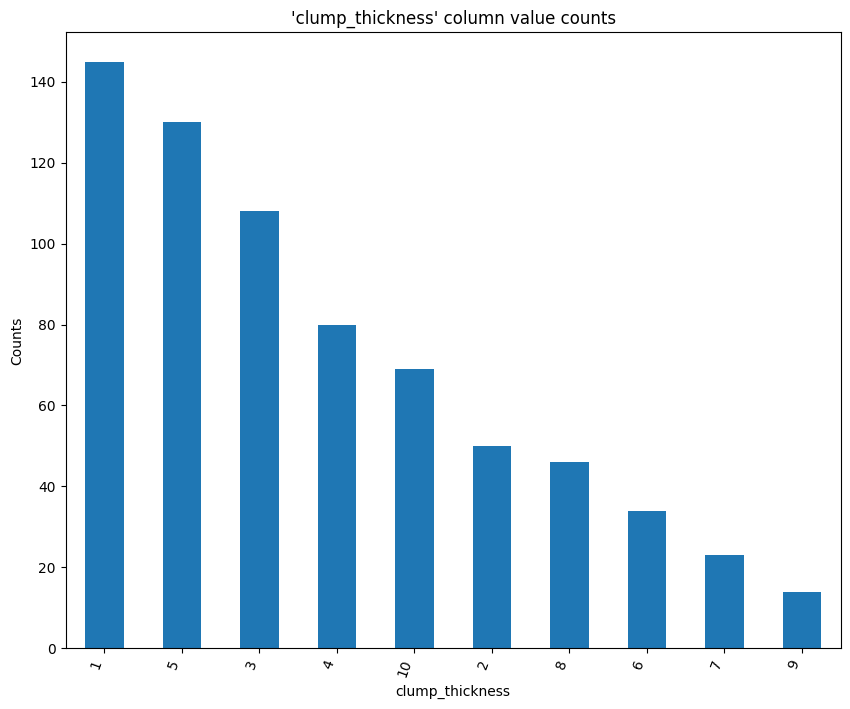

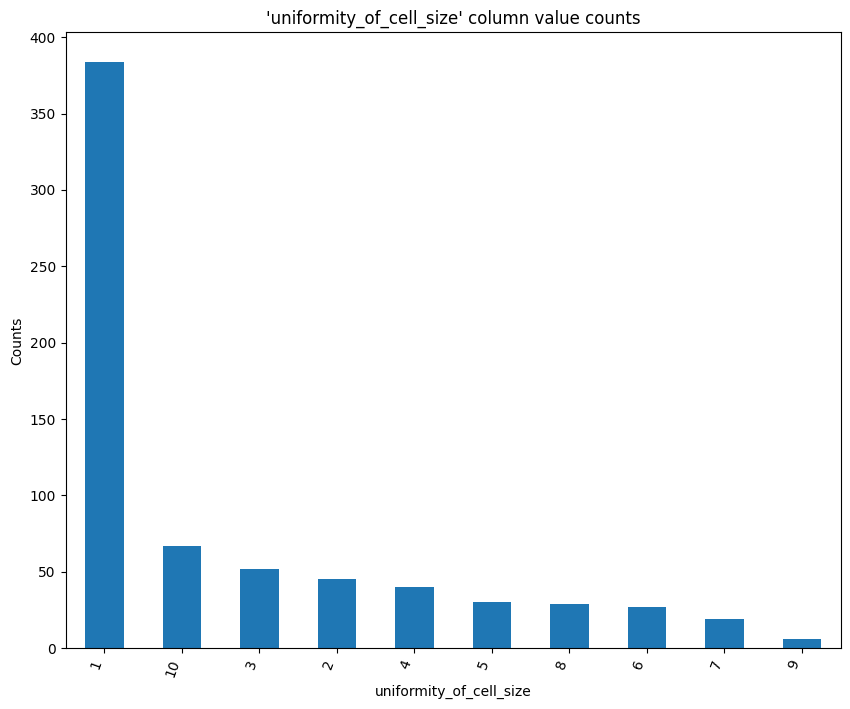

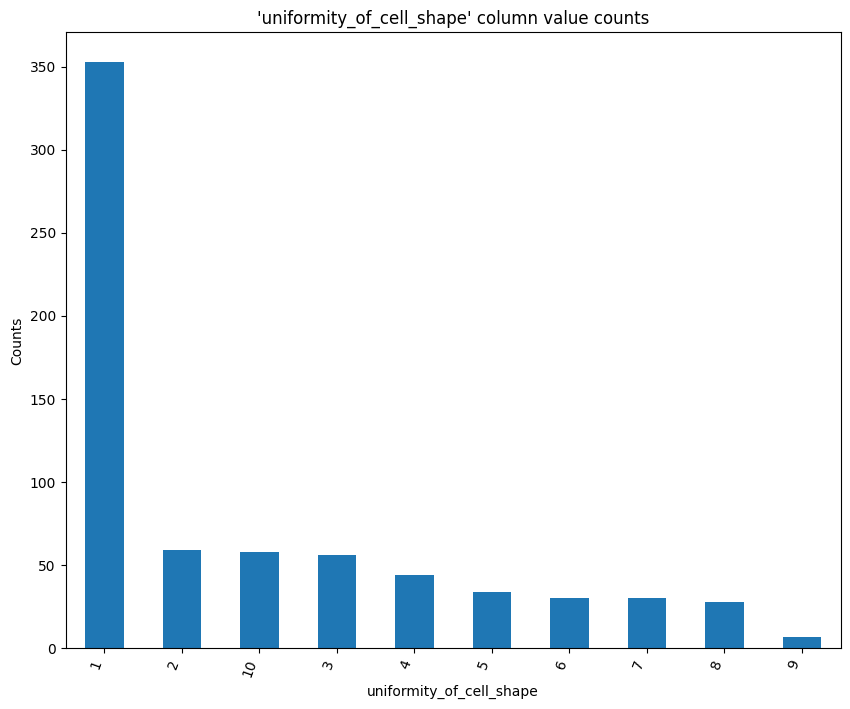

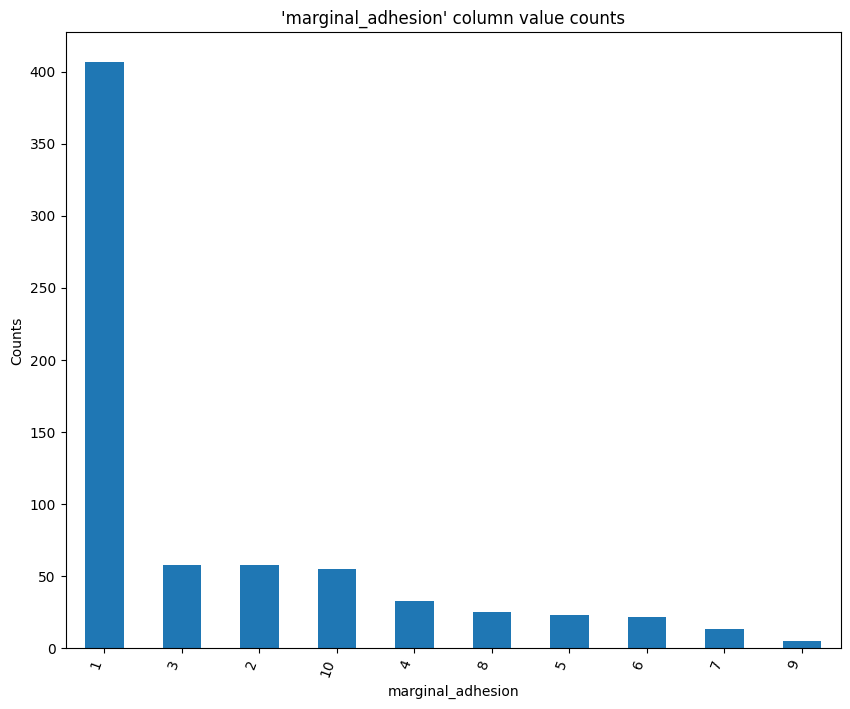

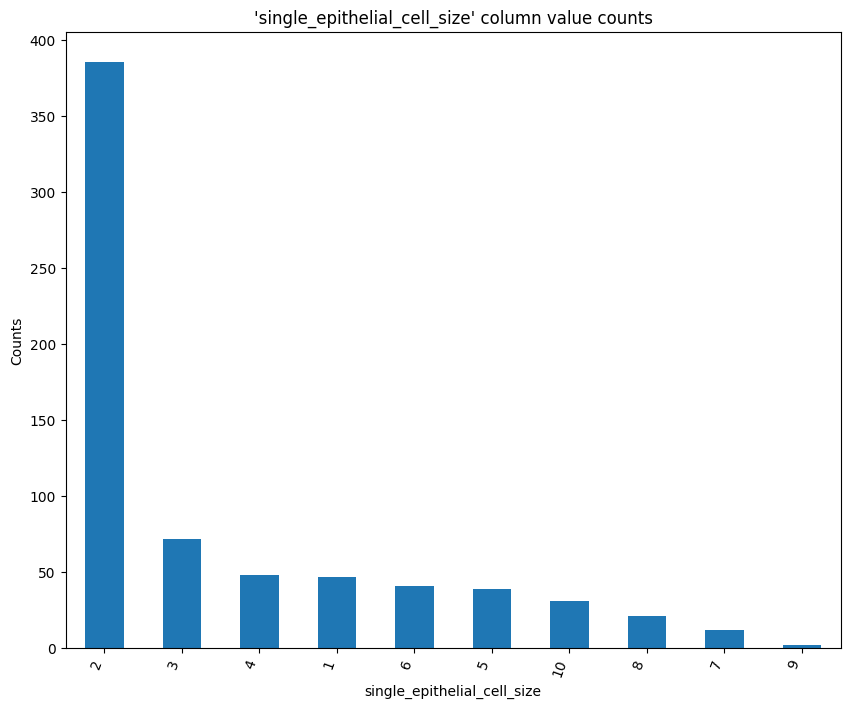

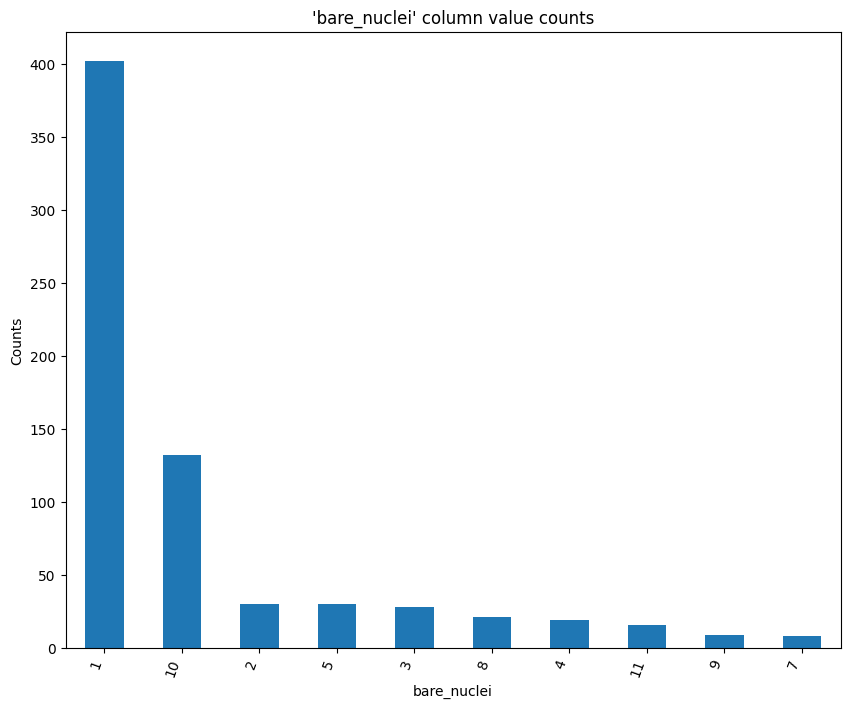

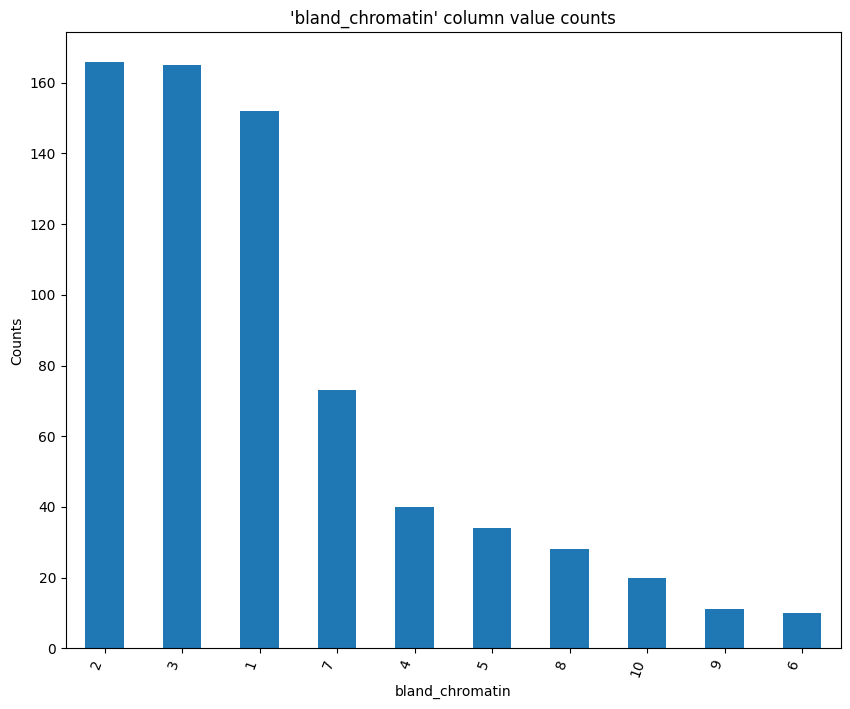

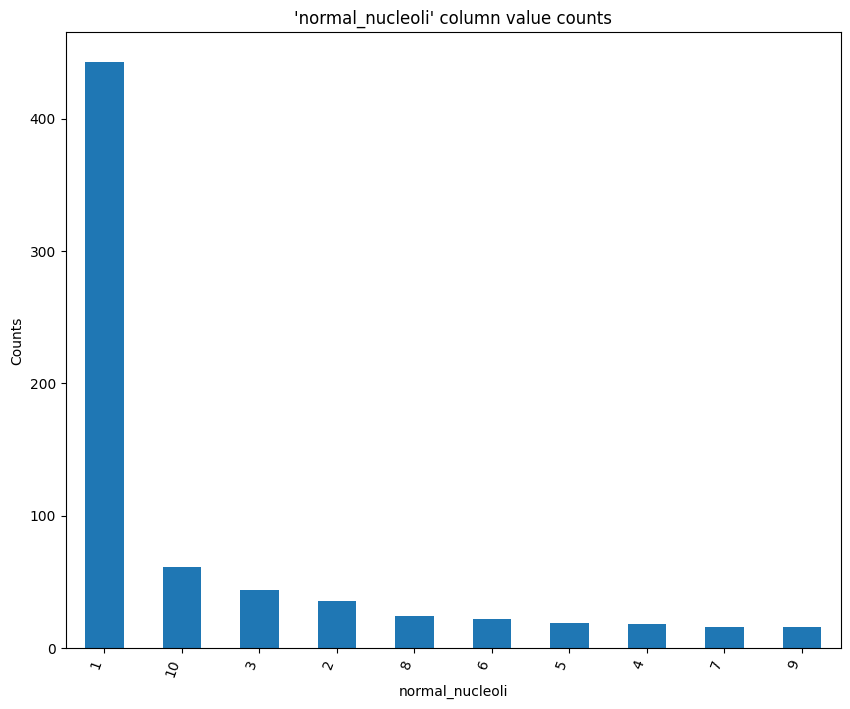

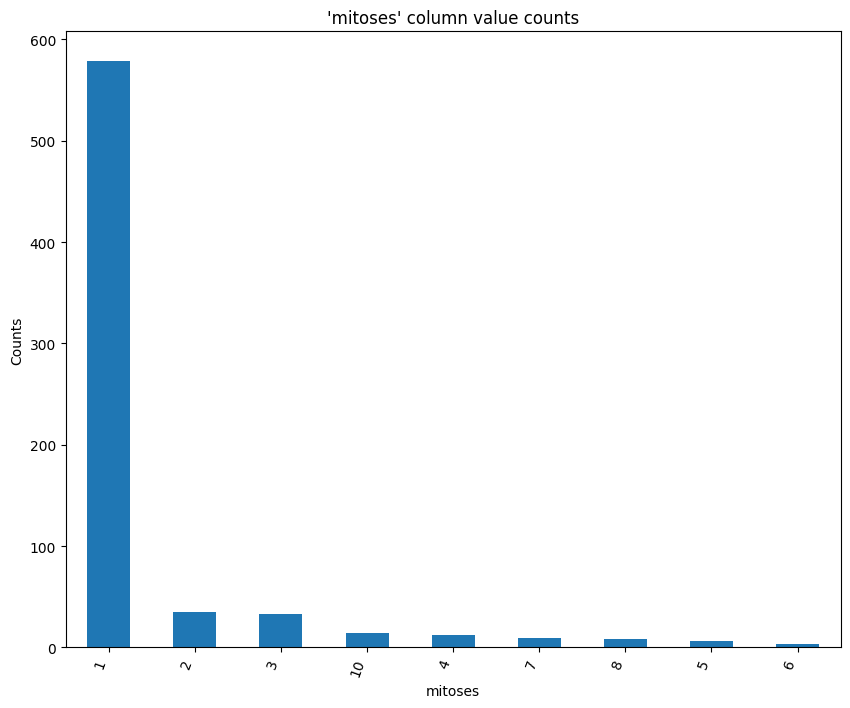

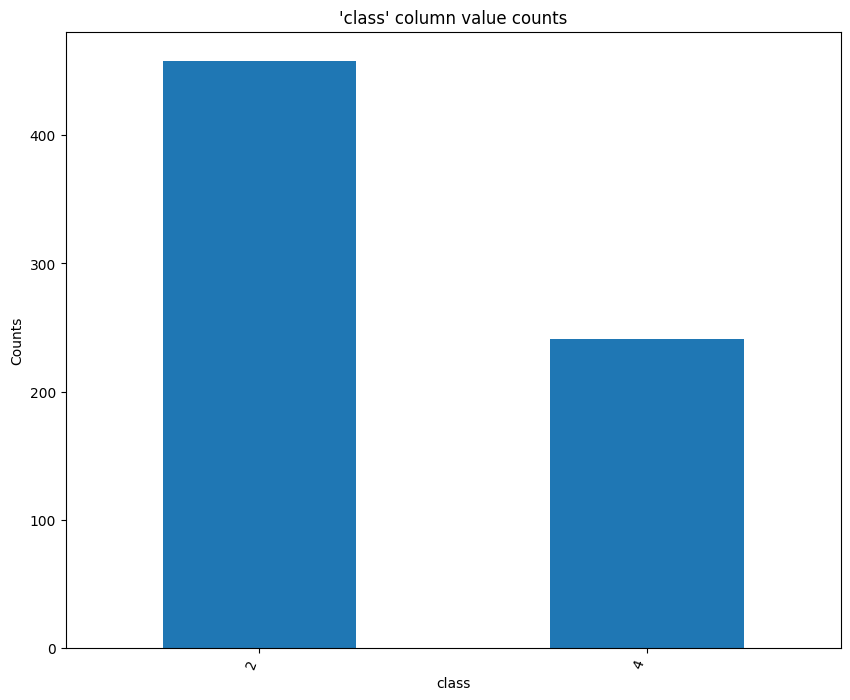

In [11]:
# Data Distribution
# Exploratory Data Analysis
def eda_plot(column, topn=10):
    plt.figure(figsize=(10, 8))
    df[column].value_counts().nlargest(topn).plot(kind='bar')
    plt.title(f"'{column}' column value counts")
    plt.ylabel("Counts")
    plt.xticks(rotation = 70, ha='right')
    plt.show()

columns = df.columns

for column in columns:
    eda_plot(column)

class
2    458
4    241
Name: count, dtype: int64


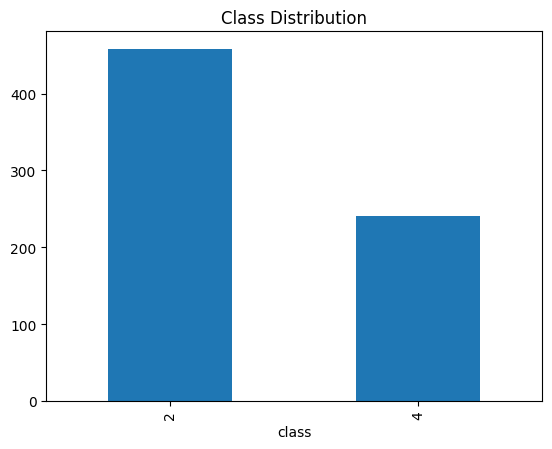

In [12]:
# Imbalance
# Visualize imbalance
print(df['class'].value_counts())
df['class'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

In [16]:
df.rename(columns={'class':'class_'}, inplace=True)

In [20]:
# Oversampling (Increase minority class)
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = df[df.class_ == 2]
df_minority = df[df.class_ == 4]

df_minority_upsampled = resample(df_minority, 
                                replace=True,     # sample with replacement
                                n_samples=len(df_majority),    # to match majority class
                                random_state=42)

# Combine majority class with upsampled minority class
df_balanced = pd.concat([df_majority, df_minority_upsampled])

# Always reset index (it’s a must to do)
df_balanced = df_balanced.reset_index(drop=True)

In [42]:
df = df_balanced

In this case I won't perform outlier removal because the data then gets corrupted, imbalanced
and unable to balance it again

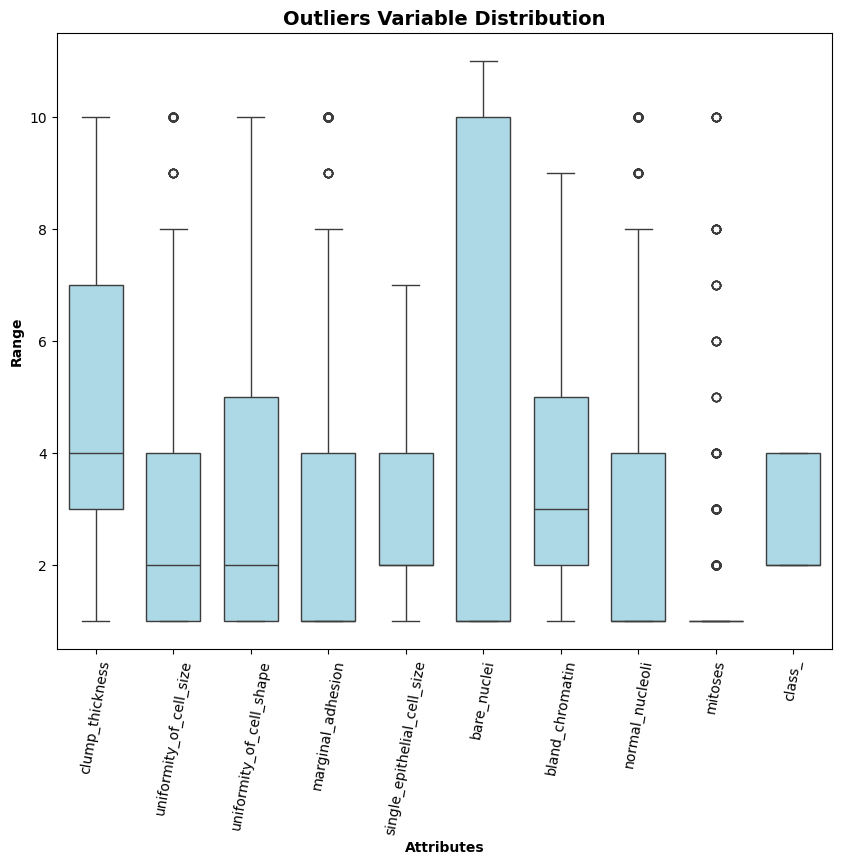

In [41]:
# Visualize Outlier Analysis of many columns at once
num_cols = df.select_dtypes(include=['int', 'float']).columns

# Option 2: Use color parameter instead of palette
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data=df[num_cols], orient="v", 
           color="lightblue", whis=1.5, saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize=14, fontweight='bold')
plt.ylabel("Range", fontweight='bold')
plt.xlabel("Attributes", fontweight='bold')
plt.xticks(rotation=80);

In [40]:
# Removing (statistical) outliers for any column one by one
Q1 = df.bland_chromatin.quantile(0.25)
Q3 = df.bland_chromatin.quantile(0.75)
IQR = Q3 - Q1
print(f"Shape {df.shape} with Outliers")
df = df[(df.bland_chromatin >= Q1 - 1.5 * IQR) & (df.bland_chromatin <= Q3 + 1.5 * IQR)]
print(f"Shape {df.shape} without Outliers")  

Shape (799, 10) with Outliers
Shape (799, 10) without Outliers


class_
2    458
4    458
Name: count, dtype: int64


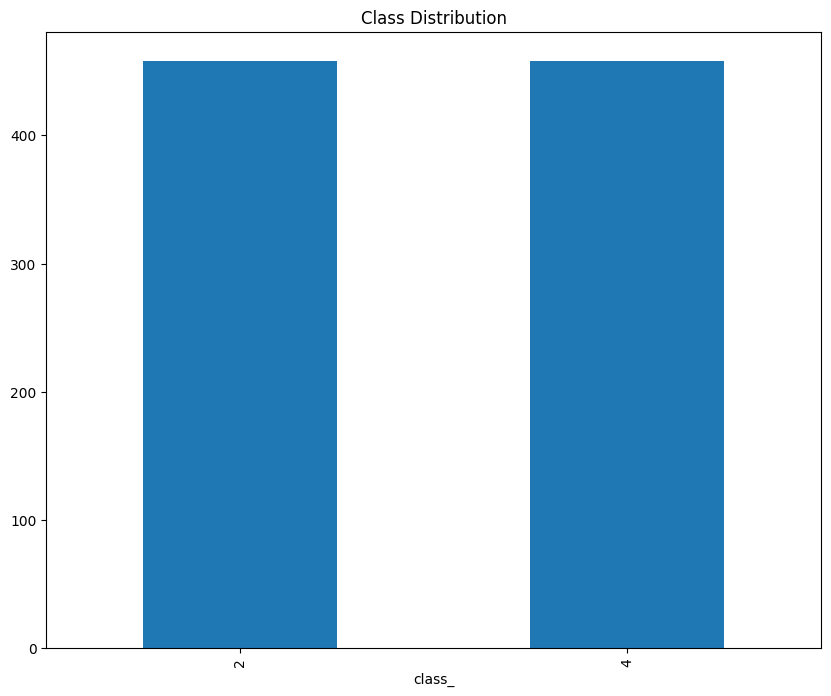

In [43]:
# Visualize imbalance
print(df['class_'].value_counts())
df['class_'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.show()

In [47]:
df['class_'].map({2:0, 4:1})

0      0
1      0
2      0
3      0
4      0
      ..
911    1
912    1
913    1
914    1
915    1
Name: class_, Length: 916, dtype: int64

In [48]:
df['class_'] = df['class_'].map({2:0, 4:1}) # (2 for benign, 4 for malignant)

Dataset shape: (916, 9)
Feature names: Index(['clump_thickness', 'uniformity_of_cell_size', 'uniformity_of_cell_shape', 'marginal_adhesion', 'single_epithelial_cell_size', 'bare_nuclei', 'bland_chromatin', 'normal_nucleoli', 'mitoses'], dtype='object')
Number of classes: 2
Class distribution: [458 458]

X Train shape: (732, 9)
Y Train shape: (732,)
X Test shape: (184, 9)
Y Test shape: (184,)
-------------------------------------------------------------------------------------------------------------------------------
--- Basic Model Performance ---
Accuracy test set: 0.9783
Accuracy train set: 0.9658

Classification Report:
Classification Report test set:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98        96
           1       0.97      0.99      0.98        88

    accuracy                           0.98       184
   macro avg       0.98      0.98      0.98       184
weighted avg       0.98      0.98      0.98       184


Classif

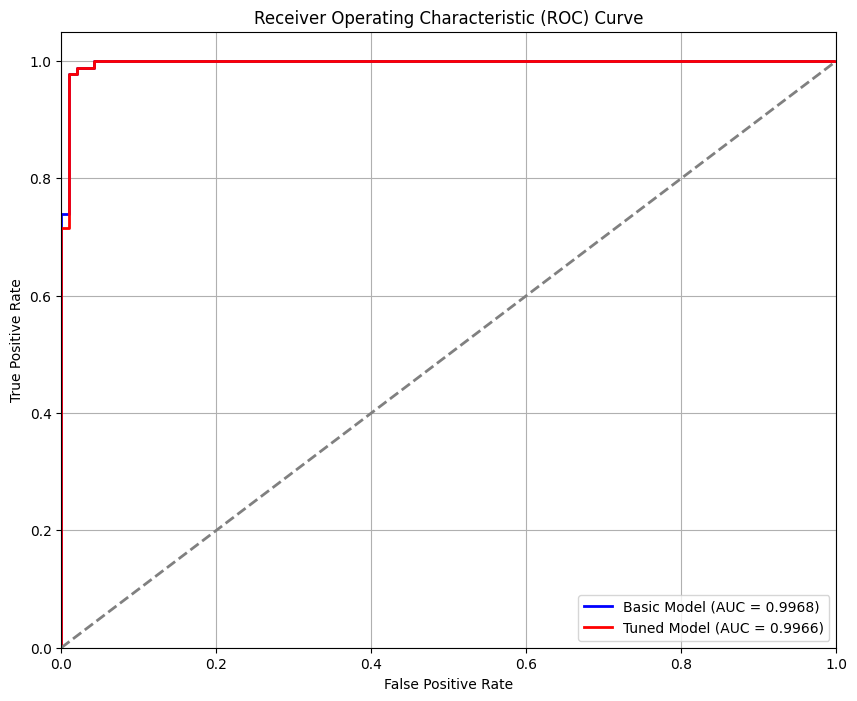

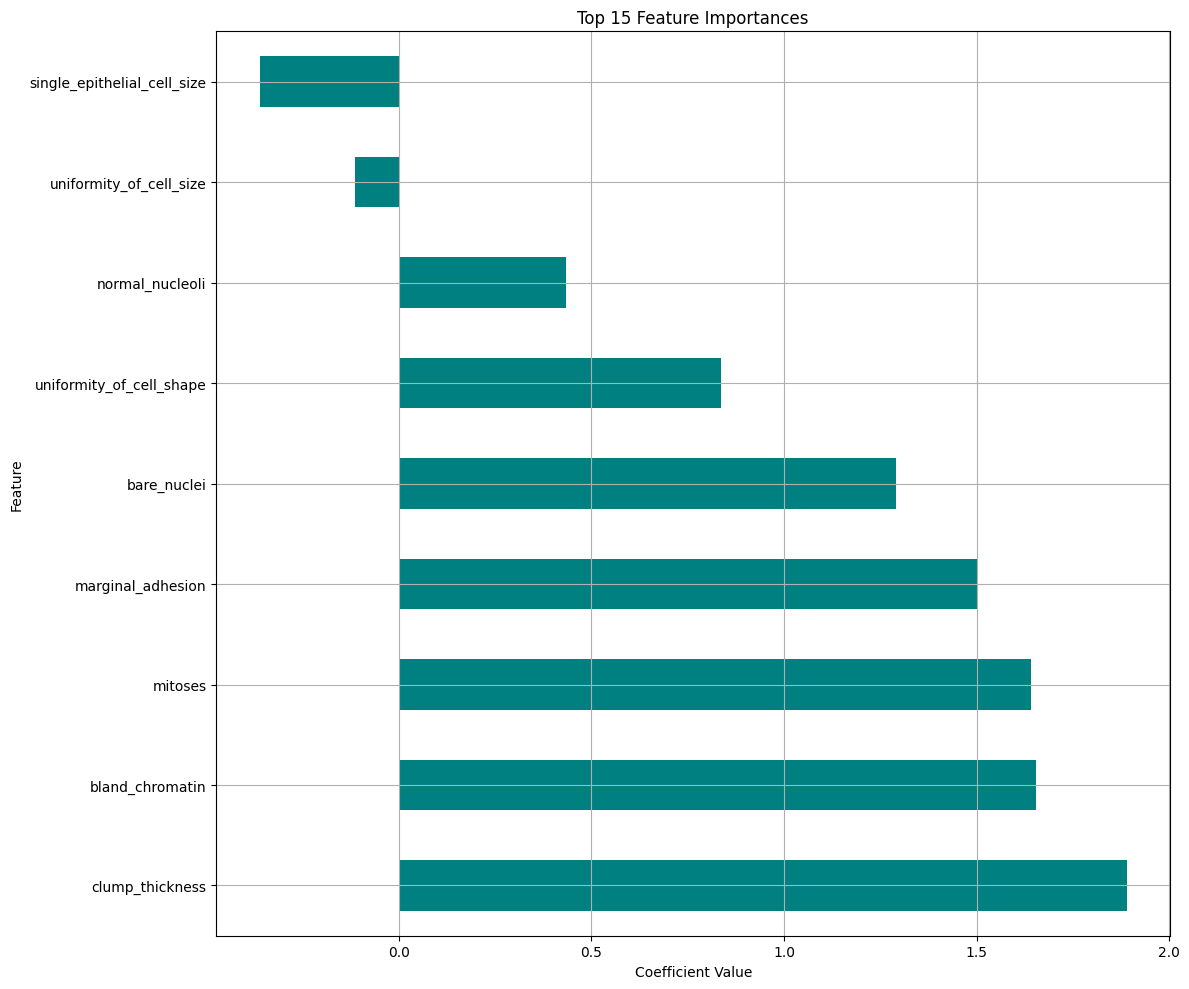

--- Top 10 Most Important Features ---
                             Coefficient
clump_thickness                 1.890183
bland_chromatin                 1.653967
mitoses                         1.640249
marginal_adhesion               1.501459
bare_nuclei                     1.291615
uniformity_of_cell_shape        0.836066
normal_nucleoli                 0.433224
uniformity_of_cell_size        -0.114070
single_epithelial_cell_size    -0.361933
--- Bottom 10 Least Important Features ---
                             Coefficient
clump_thickness                 1.890183
bland_chromatin                 1.653967
mitoses                         1.640249
marginal_adhesion               1.501459
bare_nuclei                     1.291615
uniformity_of_cell_shape        0.836066
normal_nucleoli                 0.433224
uniformity_of_cell_size        -0.114070
single_epithelial_cell_size    -0.361933
--------------------------------------------------------------------------------------------------

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/py

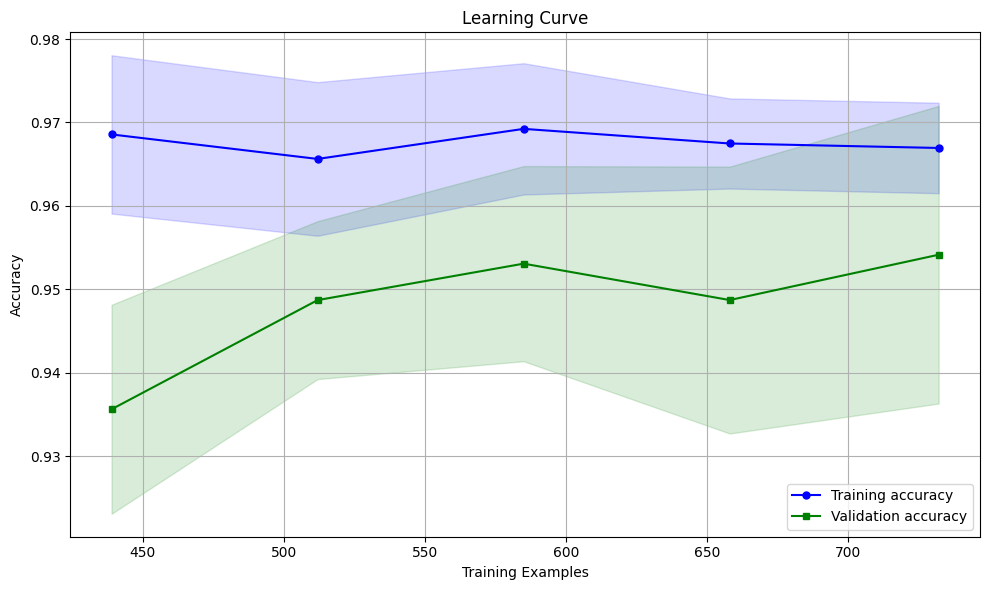

In [49]:
# Logistic Regression
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline

# Set random seed for reproducibility
np.random.seed(42)

# Load the dataset (binary classification)
X = df.drop(columns=['class_'], axis=1)
y = df['class_']

# Print dataset information
print("Dataset shape:", X.shape)
print("Feature names:", X.columns)
print(f"Number of classes: {len(np.unique(y))}")
print(f"Class distribution: {np.bincount(y)}")
print() 

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train shape:", X_train.shape)
print("Y Train shape:", y_train.shape)
print("X Test shape:",  X_test.shape)
print("Y Test shape:",  y_test.shape)
print("-" * 127) 

feature_names = X_train.columns  # or X.columns
target_names = y_train.values # or y.values 

# Basic model with default parameters 
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_train_lr = lr.predict(X_train)

# Evaluate the basic model
print("--- Basic Model Performance ---")
print(f"Accuracy test set: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train_lr):.4f}")
print("\nClassification Report:")
print(f"Classification Report test set:\n {classification_report(y_test, y_pred_lr)}\n")
print(f"Classification Report train set:\n {classification_report(y_train, y_pred_train_lr)}")
print("-" * 127)  

# Basic model with default parameters using pipeline
# Create a pipeline with preprocessing and logistic regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scale features
    ('classifier', LogisticRegression(random_state=42))  # Logistic regression model
])

pipeline.fit(X_train, y_train)
y_pred_pipeline = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

# Evaluate the basic model
print("--- Basic Model Performance Using Pipeline---")
print(f"Accuracy test set: {accuracy_score(y_test, y_pred_pipeline):.4f}")
print(f"Accuracy train set: {accuracy_score(y_train, y_pred_train):.4f}")
print("\nClassification Report:")
print(f"Classification Report test set:\n {classification_report(y_test, y_pred_pipeline)}\n")
print(f"Classification Report train set:\n {classification_report(y_train, y_pred_train)}")

# Display confusion matrix
print("—- Confusion Matrix: -—")
print(f"Confusion Matrix test set:\n {confusion_matrix(y_test, y_pred_pipeline)}\n")
print(f"Confusion Matrix train set:\n {confusion_matrix(y_train, y_pred_train)}")
print("-" * 127)  

# Hyperparameter tuning with GridSearchCV
print("--- Model With Hyperparameter Tuning ---")
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'classifier__penalty': ['l1', 'l2'],  # Regularization type
    'classifier__solver': ['liblinear', 'saga'],  # Algorithm to use
    'classifier__max_iter': [1000, 5000, 10000],      # Max iterations
    'classifier__class_weight': [None, 'balanced']  # Class weighting
}

# Create grid search with cross-validation
grid_search = GridSearchCV(
    pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best Parameters: {grid_search.best_params_}\n")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
print("-" * 127)  

# Evaluate the tuned model
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
y_pred_tuned_train = best_model.predict(X_train)
y_prob_tuned = best_model.predict_proba(X_test)[:, 1]

print("--- Tuned Model Performance ---")
print(f"Accuracy Tuned Test: {accuracy_score(y_test, y_pred_tuned):.4f}")
print(f"Accuracy Tuned Train: {accuracy_score(y_train, y_pred_tuned_train):.4f}\n")
print("Classification Report:\n")
print(classification_report(y_test, y_pred_tuned),'\n')
print(classification_report(y_train, y_pred_tuned_train))
print("-" * 127)   

# Compare basic and tuned models
print("--- Model Comparison ---")
print(f"Basic Model Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Basic Model Accuracy Pipeline: {accuracy_score(y_test, y_pred_pipeline):.4f}")
print(f"Tuned Model Accuracy GridSearch: {accuracy_score(y_test, y_pred_tuned):.4f}\n")

# Calculate cross-validation scores for both models
cv_scores_basic_lr = cross_val_score(lr, X, y, cv=5, scoring='accuracy')
cv_scores_basic_pipe = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
cv_scores_tuned_grid = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')

print(f"Basic Model Logistic Regression Cross-Validation Scores: {cv_scores_basic_lr}")
print(f"Basic Model Pipeline Cross-Validation Scores: {cv_scores_basic_pipe}")
print(f"Tuned Model GrdiSearch Cross-Validation Scores: {cv_scores_tuned_grid}\n")

print(f"Basic Model Average CV Score LR:   {cv_scores_basic_lr.mean():.4f} ± {cv_scores_basic_lr.std():.4f}")
print(f"Basic Model Average CV Score Pipe: {cv_scores_basic_pipe.mean():.4f} ± {cv_scores_basic_pipe.std():.4f}")
print(f"Tuned Model Average CV Score Grid: {cv_scores_tuned_grid.mean():.4f} ± {cv_scores_tuned_grid.std():.4f}")
print("-" * 127)  

# Plot ROC curve
plt.figure(figsize=(10, 8))

# Calculate ROC curve for basic model using pipeline 
y_prob_basic = pipeline.predict_proba(X_test)[:, 1]
fpr_basic, tpr_basic, _ = roc_curve(y_test, y_prob_basic)
roc_auc_basic = auc(fpr_basic, tpr_basic)

# Calculate ROC curve for tuned model
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_prob_tuned)
roc_auc_tuned = auc(fpr_tuned, tpr_tuned)

# Plot both curves
plt.plot(fpr_basic, tpr_basic, color='blue', lw=2, label=f'Basic Model (AUC = {roc_auc_basic:.4f})')
plt.plot(fpr_tuned, tpr_tuned, color='red', lw=2, label=f'Tuned Model (AUC = {roc_auc_tuned:.4f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
#plt.savefig('roc_curve_comparison.png')
#plt.close() 
plt.show()

# Feature importance
final_model = best_model.named_steps['classifier']
if hasattr(final_model, 'coef_'):
    # Get feature importances (coefficients)
    importances = pd.DataFrame(
        final_model.coef_[0],
        index=X_train.columns,
        columns=['Coefficient']
    ).sort_values('Coefficient', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(12, 10))
    top_features = importances.head(15)
    top_features['Coefficient'].plot(kind='barh', color='teal')
    plt.title('Top 15 Feature Importances')
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig('feature_importance.png')
    #plt.close()
    plt.show()
    
    print("--- Top 10 Most Important Features ---")
    print(importances.head(10))
    print("--- Bottom 10 Least Important Features ---")
    print(importances.tail(10))
    print("-" * 127)  

# Learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training accuracy')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='s', markersize=5, label='Validation accuracy')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('learning_curve.png')
#plt.close()
plt.show()

In [50]:
df.head()

,clump_thickness,uniformity_of_cell_size,uniformity_of_cell_shape,marginal_adhesion,single_epithelial_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,class_
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
